In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_moons, make_s_curve

from Autoencoders import IsometricAutoencoder
from helper import load_optimizer_and_scheduler, save_optimizer_and_scheduler
from data import make_half_sphere
from metrics import evaluate_conformality, isometry_jacobian_loss

random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, z):
        return self.fc(z)

In [3]:
data, labels = make_half_sphere(n_samples=3000, noise=0.05, random_state=random_state)
data = torch.tensor(data, dtype=torch.float32).to(device)
val_data, val_labels = make_half_sphere(n_samples=1000, noise=0.05, random_state=random_state+1)
val_data = torch.tensor(val_data, dtype=torch.float32).to(device)

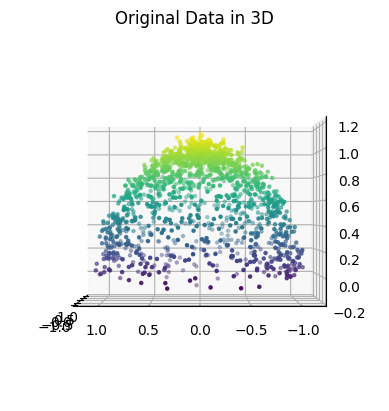

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0].cpu(), data[:, 1].cpu(), data[:, 2].cpu(), c=labels, s=5)
ax.set_title("Original Data in 3D")
ax.view_init(0, 180, 0)
plt.show()

In [5]:
# define model parameters
latent_dim = 2
input_dim = data.shape[1]
output_dim = data.shape[1]
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


dir_path = "models/isometric_autoencoder_comp_halfsphere"

In [6]:
lambda_isos = np.logspace(-3, 2, 9)
lambda_isos = np.concat([np.zeros(1), lambda_isos])

In [7]:
# from metrics import conformality_cosine_loss

In [8]:
import os

def modelpath(dir_path, lambda_iso, index):
    os.makedirs(dir_path, exist_ok=True)
    return f"{dir_path}/lambda_{lambda_iso:.3f}_model_{index+1}.pth"

In [ ]:
num_epochs = 1000
# train same model multiple times to average results
num_models = 4

recon_errors = []
regularization_errors = []
reg_metrics = []


for i, lambda_iso in enumerate(lambda_isos):
    recon_error = 0
    regularization = 0
    reg_metric = 0
    for j in range(num_models):
        print(f"Training model {j+1}/{num_models} with lambda_iso={lambda_iso:.3f}")
        
        encoder = Encoder(input_dim, latent_dim).to(device)
        decoder = Decoder(latent_dim, output_dim).to(device)
        model = IsometricAutoencoder(encoder, decoder, lambda_iso=lambda_iso).to(device)
        # model.conformality_loss = conformality_cosine_loss

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

        # Train the model
        model.train_model(train_dataloader, val_dataloader, batch_size=batch_size, epochs=num_epochs,
                          optimizer=optimizer, scheduler=scheduler, verbose=True)

        # Save the model and optimizer state
        model_path = modelpath(dir_path, lambda_iso, j)
        model.save_checkpoint(model_path)
        print(f"Model {j+1}/{num_models} with lambda_iso={lambda_iso:.3f} trained and saved.")

        # evaluation
        model.eval()
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)
        
        recon_error += nn.MSELoss()(reconstruction, val_data).item()

        regularization += model.isometry_loss(model.decoder, encoded_data).item()

        reg_metric += isometry_jacobian_loss(model.decoder, encoded_data).item()
    
    recon_errors.append(recon_error/ num_models)
    regularization_errors.append(regularization/num_models)
    reg_metrics.append(reg_metric/num_models)

Training model 1/4 with lambda_iso=0.000


/home/maxheise/anaconda3/envs/ML/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [100/1000], Loss: 0.00089085, Reconstruction Loss: 0.00089085, Isometric Loss: 0.04054044
Epoch [100/1000], Validation Loss: 0.00112754, Reconstruction Loss: 0.00112754, Isometric Loss: 0.04203242
Epoch [200/1000], Loss: 0.00081765, Reconstruction Loss: 0.00081765, Isometric Loss: 0.04706782
Epoch [200/1000], Validation Loss: 0.00107801, Reconstruction Loss: 0.00107801, Isometric Loss: 0.04842192
Epoch [300/1000], Loss: 0.00081310, Reconstruction Loss: 0.00081310, Isometric Loss: 0.04765898
Epoch [300/1000], Validation Loss: 0.00108326, Reconstruction Loss: 0.00108326, Isometric Loss: 0.04809622
Epoch [400/1000], Loss: 0.00080054, Reconstruction Loss: 0.00080054, Isometric Loss: 0.04804388
Epoch [400/1000], Validation Loss: 0.00104882, Reconstruction Loss: 0.00104882, Isometric Loss: 0.05153178
Epoch [500/1000], Loss: 0.00078677, Reconstruction Loss: 0.00078677, Isometric Loss: 0.04949967
Epoch [500/1000], Validation Loss: 0.00104505, Reconstruction Loss: 0.00104505, Isometric Lo

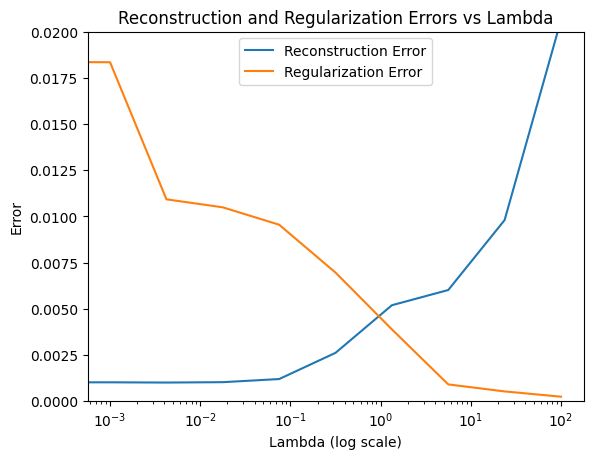

In [10]:
plt.plot(lambda_isos, recon_errors, label='Reconstruction Error')
plt.plot(lambda_isos, regularization_errors, label='Regularization Error')
plt.ylim(0, 0.02)
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Error')
plt.title('Reconstruction and Regularization Errors vs Lambda')
plt.legend()
plt.show()

In [15]:
# save results to csv
results_df = pd.DataFrame({
    'lambda_iso': lambda_isos,
    'reconstruction_error': recon_errors,
    'regularization_error': regularization_errors,
    'conformality_metric': reg_metrics
})
results_df.to_csv(f"{dir_path}/results.csv", index=False)

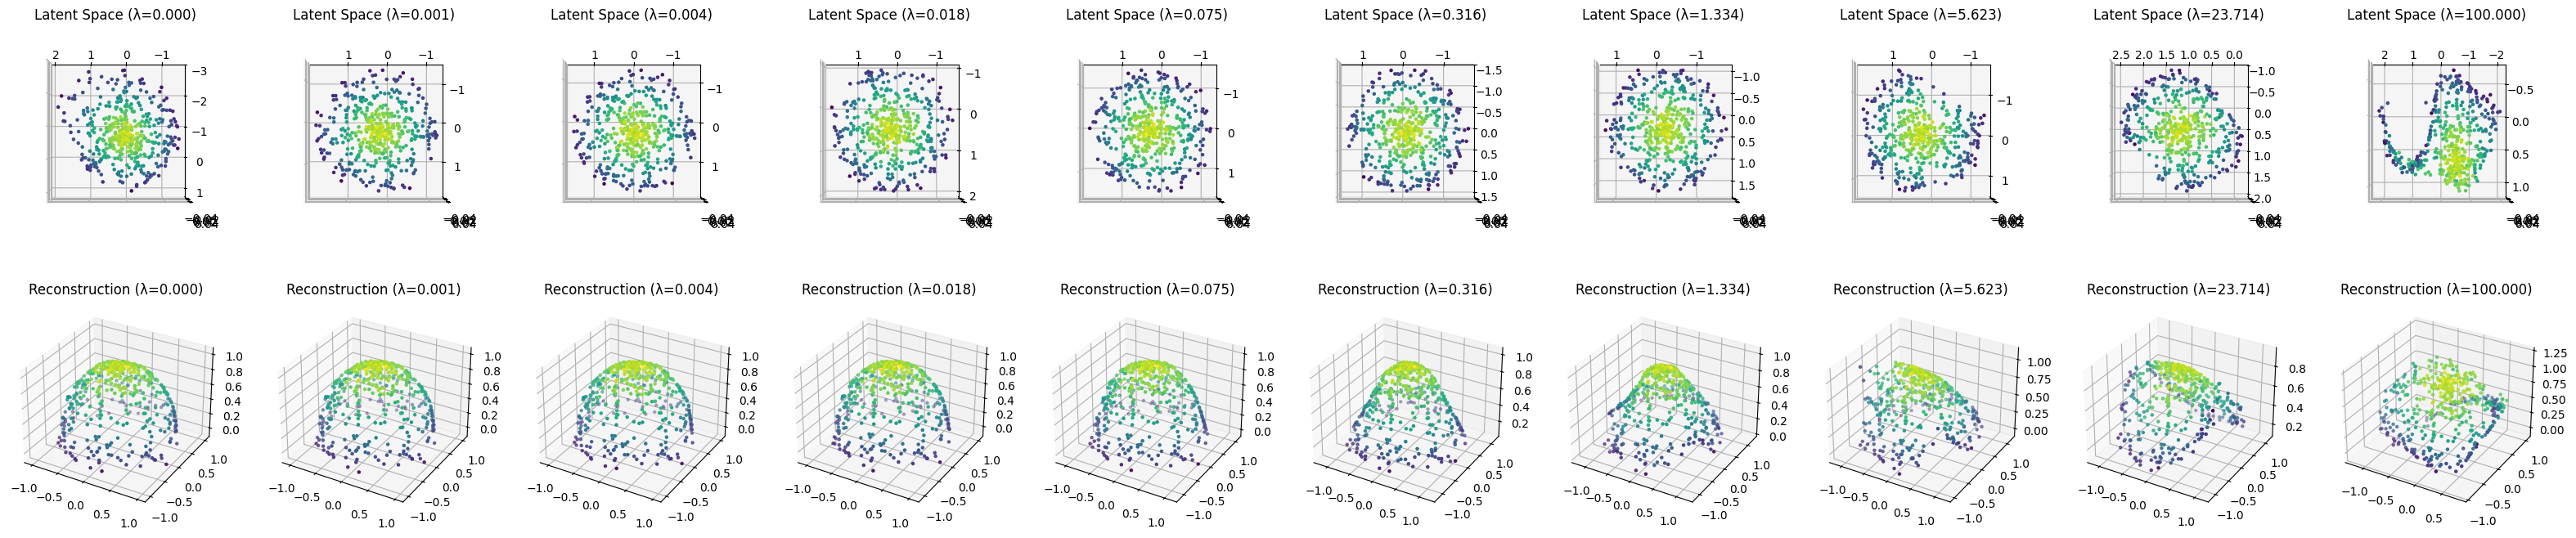

In [11]:
# plot samples and latent space at different lambdas
fig, axs = plt.subplots(2, 10, figsize=(40, 8), subplot_kw=dict(projection='3d'))
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 2)
    model = IsometricAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_iso=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    axs[0, i].scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), c=val_labels, s=5)
    axs[0, i].set_title(f'Latent Space (λ={lambda_iso:.3f})')
    axs[0, i].view_init(90, 90, 0)
    # axs[0, i].set_xticks([])
    # axs[0, i].set_yticks([])
    #plot 3d data
    axs[1, i].scatter(reconstruction[:, 0].cpu(), reconstruction[:, 1].cpu(), reconstruction[:, 2].cpu(), c=val_labels, s=5)
    axs[1, i].set_title(f'Reconstruction (λ={lambda_iso:.3f})')

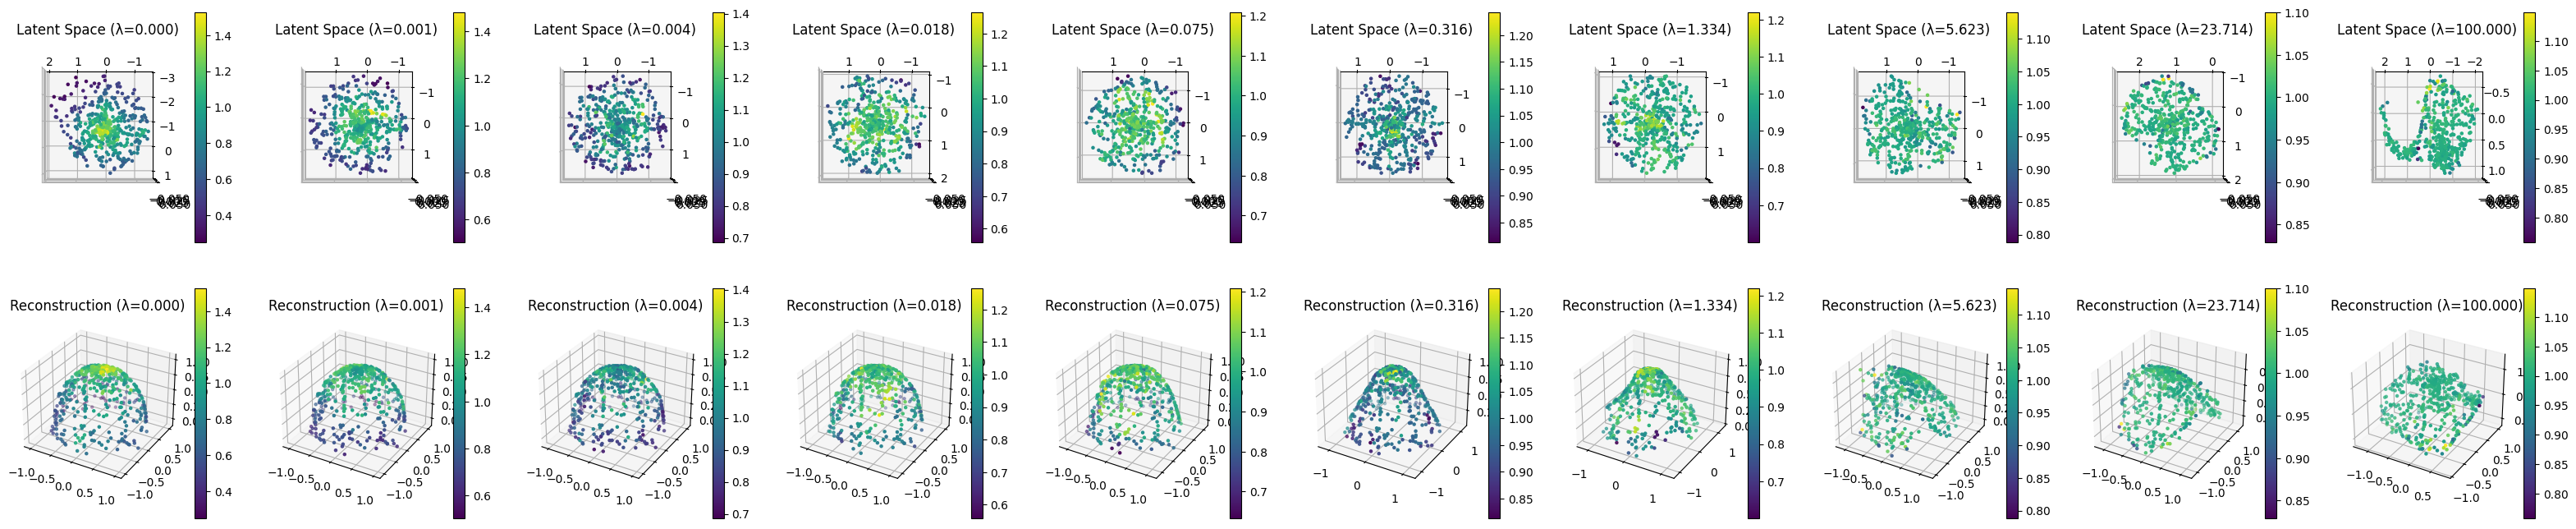

In [12]:
fig, axs = plt.subplots(2, 10, figsize=(40, 8), subplot_kw=dict(projection='3d'))
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 2)
    model = IsometricAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_iso=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    trace_vals = np.zeros_like(encoded_data[:, 0].cpu())
    for j, z in enumerate(encoded_data):
        z = z.unsqueeze(0)  # Add batch dimension
        y = model.decode(z)  # Decode to get reconstruction
        y = y.squeeze(0)  # Remove batch dimension

        # Compute the Jacobian J of the decoder at point z
        J = torch.autograd.functional.jacobian(model.decode, z)[0,:,0,:]

        # Compute the trace of J^T J
        JtJ = J.T @ J
        trace_JtJ = torch.trace(JtJ)

        # Store the trace value as a label for the point
        trace_vals[j] = trace_JtJ.item() / JtJ.shape[0]  # Normalize by the number of dimensions

    p = axs[0, i].scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), c=trace_vals, s=5)
    plt.colorbar(p)
    axs[0, i].set_title(f'Latent Space (λ={lambda_iso:.3f})')
    axs[0, i].view_init(90, 90, 0)
    # axs[0, i].set_xticks([])
    # axs[0, i].set_yticks([])
    #plot 3d data
    p = axs[1, i].scatter(reconstruction[:, 0].cpu(), reconstruction[:, 1].cpu(), reconstruction[:, 2].cpu(), c=trace_vals, s=5)
    plt.colorbar(p)
    axs[1, i].set_title(f'Reconstruction (λ={lambda_iso:.3f})')

In [16]:
statses = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 2)
    model = IsometricAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_iso=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    statses.append(evaluate_conformality(model, data)[0])

df = pd.DataFrame(statses, index=lambda_isos)
# styled_df = df.style.highlight_min(color='green').highlight_max(color='coral')

In [17]:
styled_df = df.style \
    .background_gradient(subset=[
            'reconstruction_error',
            'diagonal_gini',
            'lambda_std',
            'lambda_std_normed',
            'off_diag_mean',
            'off_diag_norm',
            'off_diag_mean_normed',
            'off_diag_norm_normed',
            'jTj_minus_lambdaI_mean',
            'jTj_minus_lambdaI_norm',
            'jTj_minus_lambdaI_mean_normed',
            'jTj_minus_lambdaI_norm_normed',
            'determinant_vs_estimate_std',
            ], cmap='Reds') \
    .background_gradient(subset=[
        'determinant_vs_estimate_mean'
    ], cmap='Greens')\
    .background_gradient(subset=[
        'lambda_mean',
        'latent_std',
        'latent_std_max',
        'latent_std_min',
        'latent_norm',
    ], cmap='Blues')

styled_df

,reconstruction_error,diagonal_gini,lambda_mean,lambda_std,lambda_std_normed,lambda_factors_meanerror,off_diag_mean,off_diag_norm,off_diag_mean_normed,off_diag_norm_normed,jTj_minus_lambdaI_mean,jTj_minus_lambdaI_norm,jTj_minus_lambdaI_mean_normed,jTj_minus_lambdaI_norm_normed,determinant_vs_estimate_mean,determinant_vs_estimate_std,determinant_vs_estimate_meanerror,determinant_vs_estimate_estimate_mean,log_determinant_vs_estimate_mean,log_determinant_vs_estimate_std,log_determinant_vs_estimate_estimate_mean,latent_std,latent_std_max,latent_std_min,latent_norm
0.000000,0.000793,0.173807,0.934168,0.285071,0.305161,0.171780,0.057092,0.161480,0.067296,0.190341,0.136669,0.308227,0.154199,0.346933,0.962881,0.033148,0.031228,1.021785,-0.038451,0.035880,-0.154093,0.655752,0.701467,0.610037,46.289738
0.001000,0.000779,0.114391,1.007331,0.194961,0.193542,0.178111,0.050861,0.143857,0.053557,0.151482,0.104963,0.228414,0.110752,0.241408,0.978847,0.028784,0.018731,1.026056,-0.021840,0.030820,-0.034956,0.596796,0.608955,0.584638,34.674175
0.004217,0.000782,0.114763,0.990346,0.119118,0.120279,0.181387,0.053371,0.150955,0.056747,0.160506,0.107985,0.240128,0.114129,0.253822,0.975505,0.031071,0.022269,1.042367,-0.025331,0.032993,-0.055465,0.604202,0.608469,0.599935,34.324234
0.017783,0.000802,0.111921,0.983446,0.113583,0.115495,0.177453,0.049124,0.138943,0.051561,0.145835,0.101188,0.228777,0.107521,0.243449,0.975774,0.035519,0.021816,1.025290,-0.025236,0.038434,-0.046211,0.605311,0.614870,0.595753,38.958809
0.074989,0.000944,0.124550,0.986120,0.100103,0.101512,0.173103,0.050925,0.144039,0.053734,0.151983,0.109362,0.240968,0.116009,0.255464,0.973451,0.035972,0.024193,1.021936,-0.027627,0.038450,-0.042832,0.605268,0.614538,0.595998,34.603077
0.316228,0.002033,0.119182,0.992269,0.068383,0.068916,0.177252,0.047626,0.134707,0.049547,0.140139,0.105009,0.232194,0.109138,0.241209,0.980258,0.020513,0.018560,1.034844,-0.020163,0.021317,-0.037487,0.590657,0.599040,0.582275,32.646999
1.333521,0.003641,0.098375,0.993667,0.085703,0.086249,0.175328,0.041379,0.117038,0.043291,0.122446,0.089175,0.201070,0.092479,0.208478,0.985361,0.016388,0.013772,1.039639,-0.014889,0.016976,-0.037316,0.583912,0.585786,0.582038,35.279610
5.623413,0.003803,0.028011,0.999151,0.039304,0.039338,0.182026,0.013765,0.038932,0.013914,0.039353,0.027527,0.060951,0.027919,0.061812,0.998253,0.006192,0.001629,1.041940,-0.001769,0.006488,-0.017664,0.610963,0.662710,0.559216,35.330971
23.713737,0.011526,0.016042,0.999716,0.023887,0.023894,0.170811,0.010014,0.028323,0.010115,0.028609,0.017969,0.040574,0.018136,0.040958,0.999279,0.002431,0.000695,1.055146,-0.000725,0.002488,-0.030674,0.558958,0.578526,0.539389,57.281422
100.000000,0.015741,0.016670,0.999490,0.026081,0.026094,0.174293,0.008117,0.022957,0.008179,0.023133,0.016399,0.036055,0.016514,0.036301,0.999302,0.001989,0.000681,1.048761,-0.000700,0.002011,-0.023414,0.647416,0.890210,0.404621,41.863388
